In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [2]:
import torch
import torchvision
from torchvision import datasets, transforms

In [22]:
transform = transforms.Compose(
    [
     transforms.Resize(255),
     transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
     transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
     ])

batch_size = 4

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=transform)

dataset = datasets.ImageFolder('data/LEGO brick images v1/culled_set', transform = transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                        download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                          shuffle=False, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes = dataset.classes
print(classes)

['3003 Brick 2x2', '3004 Brick 1x2', '3005 Brick 1x1', '3022 Plate 2x2', '3023 Plate 1x2', '3024 Plate 1x1']


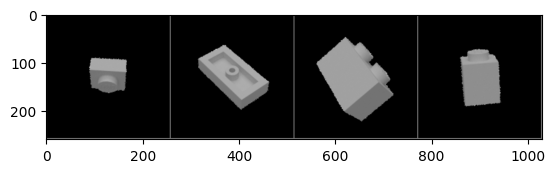

3024 Plate 1x1 3023 Plate 1x2 3004 Brick 1x2 3005 Brick 1x1


In [23]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [27]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)  # Input: 1 channel (grayscale), Output: 6 channels
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # After conv1(255x255->251x251), pool(251x251->125x125)
        # After conv2(125x125->121x121), pool(121x121->60x60)
        self.fc1 = nn.Linear(16 * 60 * 60, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 6)  # 6 output classes for the LEGO bricks

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [28]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.002, momentum=0.9)

In [30]:
for epoch in range(2):  # loop over the dataset multiple times
    print("Epoch: ",epoch)
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Epoch:  0
[1,   200] loss: 0.021
[1,   400] loss: 0.019
[1,   600] loss: 0.014
Epoch:  1
[2,   200] loss: 0.005
[2,   400] loss: 0.006
[2,   600] loss: 0.010
Finished Training


In [31]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

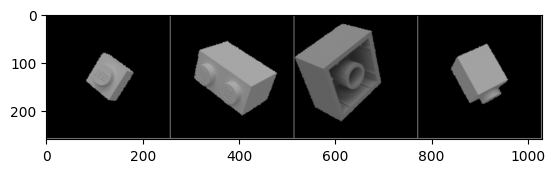

GroundTruth:  3024 Plate 1x1 3004 Brick 1x2 3003 Brick 2x2 3005 Brick 1x1
Predicted:  3024 Plate 1x1 3004 Brick 1x2 3003 Brick 2x2 3005 Brick 1x1


In [32]:
dataiter = iter(dataloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

outputs = net(images)

_, predicted = torch.max(outputs, 1)
# print(predicted)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

In [33]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 98 %


In [34]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in dataloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 3003 Brick 2x2 is 100.0 %
Accuracy for class: 3004 Brick 1x2 is 99.8 %
Accuracy for class: 3005 Brick 1x1 is 99.8 %
Accuracy for class: 3022 Plate 2x2 is 93.5 %
Accuracy for class: 3023 Plate 1x2 is 98.8 %
Accuracy for class: 3024 Plate 1x1 is 100.0 %


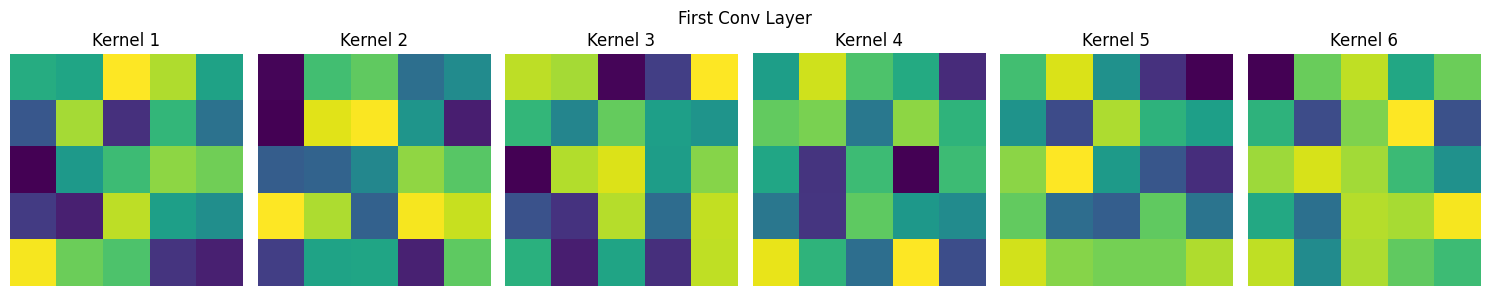

TypeError: Invalid shape (5, 5, 6) for image data

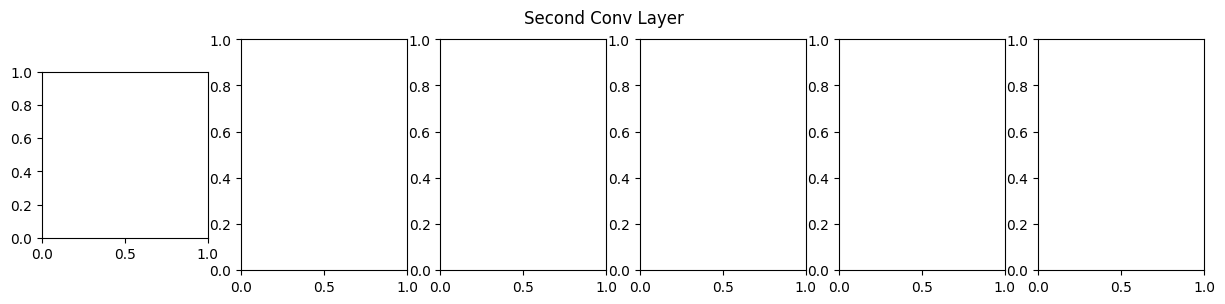

In [35]:
def visualize_conv_weights(model):
    layers = [model.conv1, model.conv2]
    layer_names = ['First Conv Layer', 'Second Conv Layer']
    
    for i, (layer, name) in enumerate(zip(layers, layer_names)):
        weights = layer.weight.data
        num_kernels = min(6, weights.size(0))  # Show up to 6 kernels
        
        fig, axes = plt.subplots(1, num_kernels, figsize=(15, 3))
        fig.suptitle(name)
        
        for j in range(num_kernels):
            kernel = weights[j].permute(1, 2, 0)  # Change to channels last format
            # Normalize kernel values for better visualization
            kernel = (kernel - kernel.min()) / (kernel.max() - kernel.min())
            axes[j].imshow(kernel)
            axes[j].axis('off')
            axes[j].set_title(f'Kernel {j+1}')
        
        plt.tight_layout()
        plt.show()

# Visualize the weights of the convolutional layers
visualize_conv_weights(net)
